# Pizza, Steak, and Sushi Classification


Requirements for execution on cloud:
- [] Update EPOCS at [Training Hyperparameters](#31-hyperparameters)
- [] Update NUM_ENCODERS at [Training Hyperparameters](#31-hyperparameters)

# 1. Import Modules

## 1.1. Configure toolbox

In [1]:
! git clone https://github.com/NareshPS/doi-ml-toolbox.git
! mv doi-ml-toolbox/torch/toolbox .
! rm -rf doi-ml-toolbox

Cloning into 'doi-ml-toolbox'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42 (delta 12), reused 39 (delta 11), pack-reused 0
Receiving objects: 100% (42/42), 892.46 KiB | 2.84 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## 1.2. Import Modules

In [2]:
import random
import torch
import torchvision
import torchinfo

from toolbox import data_download, data_setup, engine, utils, evaluation, visualization
from torchinfo import summary as model_summary
from torchvision import transforms
from torch import nn
from matplotlib import pyplot as plt
from timeit import default_timer as timer 
from pathlib import Path
from PIL import Image

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'torchinfo version: {torchinfo.__version__}')

/bin/sh: lscpu: command not found


torch version: 2.1.0.dev20230608
torchvision version: 0.16.0.dev20230608
torchinfo version: 1.8.0


# 2. Data Procurement

In [3]:
# 1. Download pizza, steak, sushi images from GitHub
image_path = data_download.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")

# 2. Setup train and test paths
train_path = image_path / "train"
test_path = image_path / "test"

print(f'Data Path: {image_path}')
print(f'Train Path: {train_path}')
print(f'Test Path: {test_path}')

[INFO] /Users/broxoli/.datasets/pizza_steak_sushi directory exists. Skipping download.
Data Path: /Users/broxoli/.datasets/pizza_steak_sushi
Train Path: /Users/broxoli/.datasets/pizza_steak_sushi/train
Test Path: /Users/broxoli/.datasets/pizza_steak_sushi/test


# 3. Create Datasets and DataLoaders

Steps:
1. Setup Hyperparameters
2. Choose a pretrained model for weights.
3. Load transforms from the pretrained model.
4. Initialize Dataloaders.

## 3.1. Hyperparameters

In [5]:
EPOCHS = 2
BATCH_SIZE = 32
SEED = 3

IMG_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 3

NUM_ENCODERS = 1

## 3.2. Prepare Image Transform

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Image Transform: {transform}')

Image Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


## 3.3. Initialize DataLoaders

In [8]:
# Create train and test dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_path=train_path,
    test_path=test_path,
    transform=transform,
    batch_size=BATCH_SIZE
)

Training Set
------------
Dataset ImageFolder
    Number of datapoints: 225
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}

Test Set
------------
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


## 3.4. Visualize Single Input

Image Shape: torch.Size([3, 224, 224])
Label: 0


(-0.5, 223.5, 223.5, -0.5)

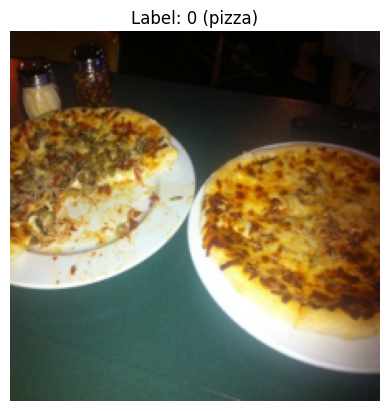

In [9]:
# 1. Get a single input
image, label = train_dataloader.dataset[0]

# 2. View input shapes
print(f'Image Shape: {image.shape}')
print(f'Label: {label}')

# 3. Visualize
image_permute = image.permute(1, 2, 0)
plt.imshow(image_permute)
plt.title(f'Label: {label} ({class_names[label]})')
plt.axis(False)

# 4. Neural Architecture Search

Questions:
- Which framework to use?
- How do we configure the search space?

# 5. Create an Optimizer

## Hyperparamters

In [24]:
WEIGHT_DECAY = 0.3

## Initialize the optimizer with hyperparameters

In [25]:
optimizer = torch.optim.Adam(params=vit.parameters(), weight_decay=WEIGHT_DECAY)

print(f'Optimizer: {optimizer}')

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.3
)


# 6. Create loss and accuracy functions

In [26]:
# 1. Initialize a cross-entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# 2. Initialize an accuracy function
accuracy_fn = utils.accuracy_fn

print(f'Loss Function: {loss_fn}')
print(f'\nAccuracy Function: {accuracy_fn}')

Loss Function: CrossEntropyLoss()

Accuracy Function: <function accuracy_fn at 0x13cb4d080>


# 7. Training

## 7.1. Device Selection

In [28]:
device = utils.get_device()

print(f'Device: {device}')

Device: mps


## 7.2. Loop

In [29]:
print('Training Loop')
print('-------------')
print('-------------')

training_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    epochs=EPOCHS,
    device=device
)

print('Training Results')
print('----------------')
for k, v in training_results.items():
    print(f'{k}: {v}')

Training Loop
-------------
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3419 | train_acc: 0.2773 | test_loss: 1.4558 | test_acc: 0.3400
Epoch: 2 | train_loss: 1.1556 | train_acc: 0.3984 | test_loss: 1.1604 | test_acc: 0.4025


## 7.3. Metrics

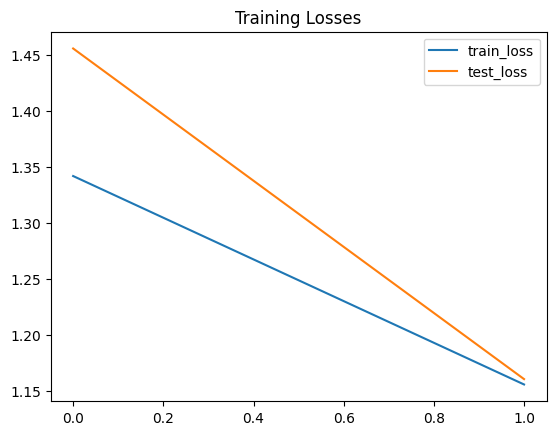

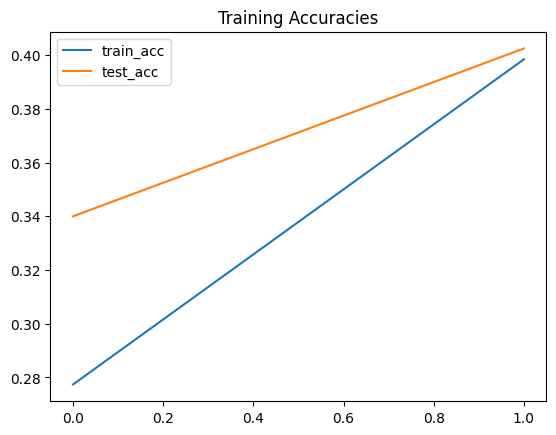

In [128]:
visualization.plot_training_metrics(model_results, keys=['train_loss', 'test_loss'], title='Training Losses')
visualization.plot_training_metrics(model_results, keys=['train_acc', 'test_acc'], title='Training Accuracies')

# 8. Saving the Model

In [81]:
# 1. Define model name and store location
MODELS_STORE = Path("models")
MODEL_NAME = "vision-transformer.pth"

# 2. Save the model
utils.save_model(vit, MODELS_STORE, MODEL_NAME)

[INFO] Saving model to: models/vision-transformer.pth


# 9. Making Predictions

## 9.1. Pick Random Samples for Prediction

In [86]:
test_samples = []
test_labels = []
num_samples = 9

class_names = train_dataloader.dataset.classes
test_samples, test_labels = evaluation.pick_random_samples(
    dataset=test_dataloader.dataset, num_samples=num_samples, seed=SEED
)

print("Test Sample")
print("------------")
print(
    f"Image Shape: {test_samples[0].shape} Label: {test_labels[0]} ({class_names[test_labels[0]]})"
)

Test Sample
------------
Image Shape: torch.Size([3, 224, 224]) Label: 1 (steak)


## 9.2. Compute Class Probabilities

In [87]:
pred_probs = evaluation.make_predictions(model=vit, data=test_samples, device=device)

print("Sample Probabilities")
print("--------------------")
print(f"pred_probs: {pred_probs}")

Sample Probabilities
--------------------
pred_probs: tensor([[0.2676, 0.1540, 0.5784],
        [0.2684, 0.1540, 0.5777],
        [0.2685, 0.1539, 0.5776],
        [0.2688, 0.1538, 0.5775],
        [0.2682, 0.1538, 0.5779],
        [0.2681, 0.1539, 0.5781],
        [0.2685, 0.1540, 0.5775],
        [0.2696, 0.1538, 0.5767],
        [0.2696, 0.1538, 0.5767]])


## 9.3. Predicted Classes

In [88]:
pred_classes = pred_probs.argmax(dim=1)

print('Predicted Classes')
print('-----------------')
print(f'pred_classes: {list(pred_classes.numpy())}')
print(f'test_labels : {test_labels}')

Predicted Classes
-----------------
pred_classes: [2, 2, 2, 2, 2, 2, 2, 2, 2]
test_labels : [1, 2, 2, 2, 2, 2, 0, 2, 0]


## 9.4. Visualize Results

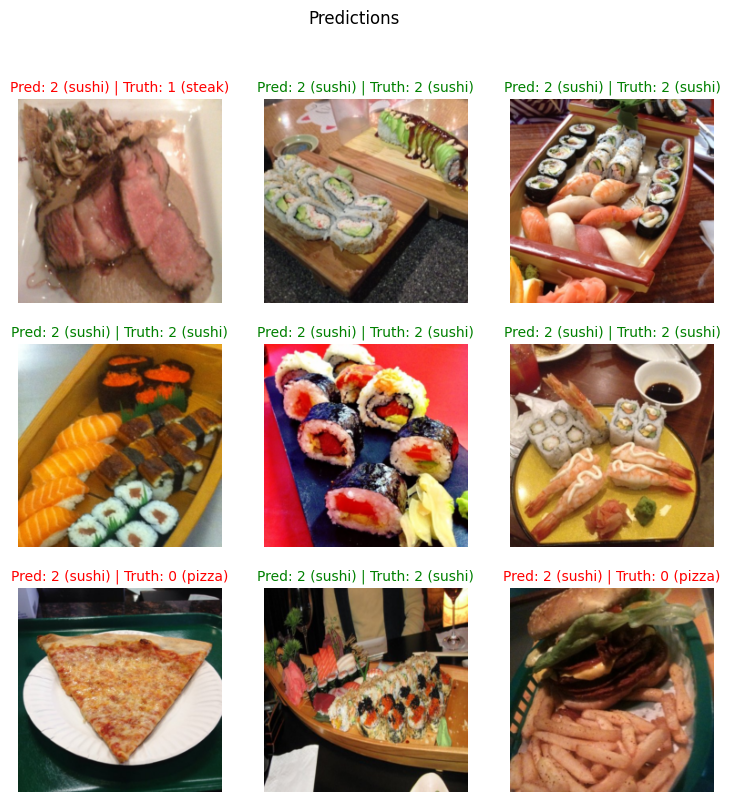

In [96]:
visualization.plot_image_classification(
    items=test_samples,
    targets=test_labels,
    predictions=pred_classes,
    class_names=class_names,
    item_size=3,
    rows=3,
)

# 10. Performance Evaluation

## 10.1. Compute Predictions for Test Set

In [103]:
y_pred_tensor = utils.timed_execution(
    evaluation.make_predictions_on_dataset,
    model=vit,
    dataloader=test_dataloader,
    device=device,
)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

Total Execution Time: 22.768 seconds


## 10.2. Compute Confusion Matrix

Total Execution Time: 0.022 seconds


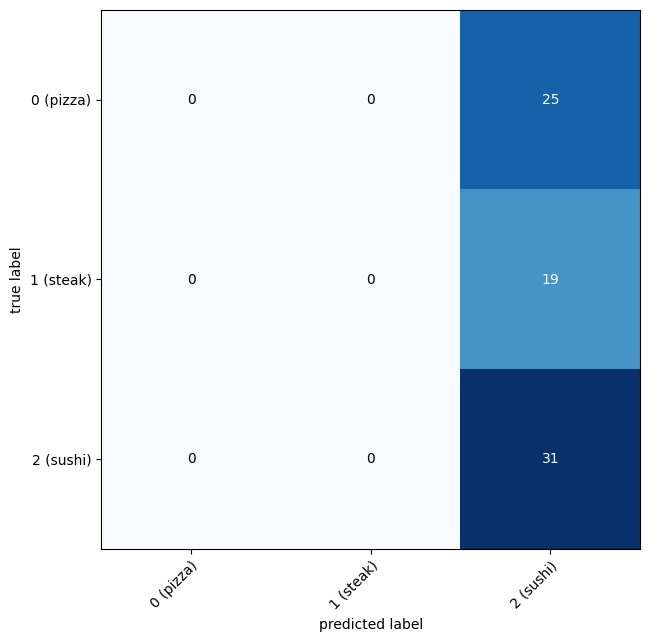

In [105]:
utils.timed_execution(
    visualization.plot_confusion_matrix,
    dataset=test_dataloader.dataset,
    class_names=test_dataloader.dataset.classes,
    preds=y_pred_tensor,
    figsize=(8, 6),
)